# Exercise 3: Stommel gyre on a C-staggered grid

Staggered grids are a natural discretisation for flows deriving from a stream function.

The objective of this exercise is to write a Stommel flow on a C grid.

* To tell Parcels that you define a c-grid, use the flag `interp_method='cgrid_linear'` within the `RectilinearZGrid` options


In [1]:
from parcels import Field, RectilinearZGrid, FieldSet
import numpy as np
import math

# Some constants
A = 10
eps = 0.05
a = 10000
b = 10000

# Coordinates of the test fieldset (on A-grid)
xdim = 200
ydim = 400
lon = np.linspace(0, a, xdim, dtype=np.float32)
lat = np.linspace(0, b, ydim, dtype=np.float32)
dx = lon[1]-lon[0]
dy = lat[1]-lat[0]
(x, y) = np.meshgrid(lon, lat)

l1 = (-1 + math.sqrt(1 + 4 * math.pi**2 * eps**2)) / (2 * eps)
l2 = (-1 - math.sqrt(1 + 4 * math.pi**2 * eps**2)) / (2 * eps)
c1 = (1 - math.exp(l2)) / (math.exp(l2) - math.exp(l1))
c2 = -(1 + c1)

P = A * (c1*np.exp(l1*x/a) + c2*np.exp(l2*x/a) + 1) * np.sin(np.pi * y/b)
U = np.zeros(P.shape)
V = np.zeros(P.shape)
U[1:,:] =  - (P[1:,:]-P[:-1,:])/dy
V[:,1:] =    (P[:,1:]-P[:,:-1])/dx

grid = RectilinearZGrid(lon=lon, lat=lat)
ufield = Field('U', U, grid=grid, interp_method='cgrid_linear')
vfield = Field('V', V, grid=grid, interp_method='cgrid_linear')
pfield = Field('P', P, grid=grid, interp_method='linear')
fieldset = FieldSet(ufield, vfield, {'P':pfield})

INFO: Compiled MyParticleAdvectionEEUpdateP ==> /var/folders/h0/01fvrmn11qb62yjw7v1kn62r0000gq/T/parcels-503/b7273f089a695b75bea769f15f9ddde9.so


lon: 3277.04, lat: 9208.73, time: 4.32e+06, p: 0.679673, p_start: 0.678165
lon: 3330.05, lat: 8970.83, time: 4.32e+06, p: 0.871985, p_start: 0.870433
lon: 3339.52, lat: 8746.16, time: 4.32e+06, p: 1.0521, p_start: 1.05293
lon: 3327.7, lat: 8527.11, time: 4.32e+06, p: 1.22546, p_start: 1.2251


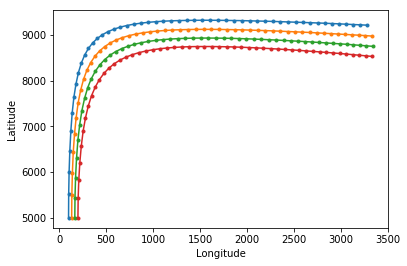

<module 'matplotlib.pyplot' from '/Users/delandmeter/anaconda2/envs/py2_parcels/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [2]:
from parcels import Variable, JITParticle, ScipyParticle, ParticleSet, AdvectionEE
from datetime import timedelta as delta

class MyParticle(JITParticle):
    p = Variable('p', dtype=np.float32, initial=0.)
    p_start = Variable('p_start', dtype=np.float32, initial=fieldset.P)

def UpdateP(particle, fieldset, time, dt):
    particle.p = fieldset.P[time, particle.lon, particle.lat, particle.depth]

pset = ParticleSet.from_line(fieldset, size=4, pclass=MyParticle,
                             start=(100, 5000), finish=(200, 5000), time=0)

runtime = delta(days=50)
dt = delta(minutes=1)

output_file = pset.ParticleFile(name="StommelCParticle", outputdt=delta(days=1))
pset.execute(AdvectionEE + pset.Kernel(UpdateP), runtime=runtime, dt=dt,
             output_file=output_file)


for p in pset:
    print("lon: %g, lat: %g, time: %g, p: %g, p_start: %g" % (p.lon, p.lat, p.time, p.p, p.p_start) )

from parcels import plotTrajectoriesFile
plotTrajectoriesFile('StommelCParticle.nc')